In [1]:
# code for loading the format for the notebook
import os

# path : store the current path to convert back to it later
path = os.getcwd()
os.chdir(os.path.join('..', 'notebook_format'))
from formats import load_style
load_style(css_style = 'custom2.css')

In [2]:
os.chdir(path)

# 1. magic for inline plot
# 2. magic to print version
# 3. magic so that the notebook will reload external python modules
%matplotlib inline
%load_ext watermark
%load_ext autoreload 
%autoreload 2

# if you get a deprecation warning, 
# it is coming from XGBClassifier, since it's still using
# from sklearn.cross_validation import RandomizedSearchCV
# instead of the preferable new api
# from sklearn.model_selection import RandomizedSearchCV
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from operator import itemgetter
from xgboost import XGBClassifier
from scipy.stats import randint, uniform
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

%watermark -a 'Ethen' -d -t -v -p numpy,pandas,xgboost,sklearn,matplotlib

Ethen 2017-09-22 16:18:54 

CPython 3.5.2
IPython 6.1.0

numpy 1.13.1
pandas 0.20.3
xgboost 0.6
sklearn 0.18.1
matplotlib 2.0.0


# XGBoost 

Quoted from [Quora: What is the difference between the R gbm (gradient boosting machine) and xgboost (extreme gradient boosting)?](https://www.quora.com/What-is-the-difference-between-the-R-gbm-gradient-boosting-machine-and-xgboost-extreme-gradient-boosting/answer/Tianqi-Chen-1)

> Both xgboost (Extreme gradient boosting) and gbm follows the principle of gradient boosting. The name xgboost, though, actually refers to the engineering goal to push the limit of computations resources for boosted tree algorithms. Which is the reason why many people use xgboost. For model, it might be more suitable to be called as regularized gradient boosting, as it uses a more regularized model formalization to control overfitting.

## Preparation <a name='preparation' />

For installing xgboost on mac: 

```bash
# install gcc from brew, 
# note that the second command can 
# take up to 30 minutes, be patient
brew tap homebrew/versions
brew install gcc --without-multilib

# install xgboost
git clone --recursive https://github.com/dmlc/xgboost 
cd xgboost

# open make/config.mk and uncomment these two lines

# export CC = gcc
# export CXX = g++

# but depending on the installation, we may need to change
# the two lines above to

# export CC = gcc-7
# export CXX = g++-7

# we can check the number after the "-" by entering 
# brew install gcc --without-multilib
# it will warn us the version if we already have it

# start the build
cp make/config.mk .
make -j4

cd python-package 
sudo python setup.py install

```

In this toy example, we will be dealing with a **binary classification** task. We start off by generating a 20 dimensional artificial dataset with 1000 samples, where 8 features holding information, 3 are redundant and 2 repeated. And perform a train/test split. The testing data will be useful for validating the performance of our algorithms.

In [3]:
seed = 104
X, y = make_classification(n_samples = 1000, n_features = 20, 
                           n_informative = 8, n_redundant = 3, 
                           n_repeated = 2, random_state = seed)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = seed)

# confirm that the dataset is balanced,
# that is the target variable is equally 
# distributed across both dataset
print('Train label distribution:')
print(np.bincount(y_train))

print('\nTest label distribution:')
print(np.bincount(y_test))

Train label distribution:
[396 404]

Test label distribution:
[106  94]


In [4]:
# we can establish a decision tree classifier as a baseline,
# and see if a more complex model will beat it
tree = DecisionTreeClassifier(random_state = seed, max_depth = 6)

# train classifier
tree.fit(X_train, y_train)

# predict output
tree_y_pred = tree.predict(X_test)
tree_y_pred_prob = tree.predict_proba(X_test)[:, 1]

# evaluation
tree_auc = roc_auc_score(y_test, tree_y_pred_prob)
print('auc:', tree_auc)

auc: 0.847400642312


## XGBoost Basics

We start by training a xgboost model using a fix set of parameters. For further details of the parameter (using scikit-learn like API) refer to the [XGBoost Documentation: Python API documentation](http://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn). 

In [5]:
xgb_params_fixed = {
    'learning_rate': 0.1,
    
    # use 'multi:softprob' for multi-class problems
    'objective': 'binary:logistic',
    
    # length of the longest path from a root to a leaf
    'max_depth': 6,
    
    # subsample ratio of columns when constructing each tree
    'colsample_bytree': 0.8,
    
    # setting it to a positive value 
    # might help when class is extremely imbalanced
    # as it makes the update more conservative
    'max_delta_step': 1, 
    'n_estimators': 150,
    
    # use all possible cores for training
    'n_jobs': -1
}
model_xgb = XGBClassifier(**xgb_params_fixed)

# we also specify the evaluation dataset and metric
# to record the model's performance history, note that
# we can supply multiple evaluation metric by passig a 
# list to `eval_metric`
eval_set = [(X_train, y_train), (X_test, y_test)]
model_xgb.fit(X_train, y_train, eval_metric = 'auc', eval_set = eval_set, verbose = False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=1,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=150,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

We can retrieve the performance of the model on the evaluation dataset and plot it to get insight into the training process. The `evals_results_` dictionary stores the `validation_0` and `validation_1` as its first key. This corresponds to the order that datasets were provided to the `eval_set` argument. The second key is the `eval_metric` that were provided.

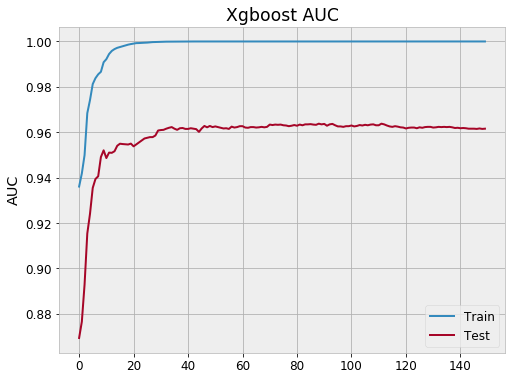

In [6]:
# change default figure and font size
plt.rcParams['figure.figsize'] = 8, 6 
plt.rcParams['font.size'] = 12

history = model_xgb.evals_result_
x_axis = range(len(history['validation_0']['auc']))
plt.plot(x_axis, history['validation_0']['auc'], label = 'Train')
plt.plot(x_axis, history['validation_1']['auc'], label = 'Test')
plt.legend(loc = 'best')
plt.ylabel('AUC')
plt.title('Xgboost AUC')
plt.show()

From reviewing the plot, it looks like there is an opportunity to stop the learning early, since the auc score for the testing dataset stopped increasing around 80 estimators. Luckily, xgboost supports this functionality.

Early stopping works by monitoring the performance of the model that is being trained on a separate validation or test dataset and stopping the training procedure once the performance on the validation or test dataset has not improved after a fixed number of training iterations (we can specify the number). This will potentially save us a lot of time from training a model that does not improve its performance over time.

The evaluation measure may be the loss function that is being optimized to train the model (such as logarithmic loss), or an external metric of interest to the problem in general (such as the auc score that we've used above). The full list of performace measure that we can directly specify can be found at the `eval_metric` section of the [XGBoost Doc: Learning Task Parameters](http://xgboost.readthedocs.io/en/latest//parameter.html#learning-task-parameters).

In addition to specifying a evaluation metric and dataset, to use early stopping we also need to specify the `early_stopping_rounds`. This is essentially telling the model to stop the training process if the evaluation dataset's evaluation metric does not improve over this many rounds. Note that if multiple evaluation datasets or multiple evaluation metrics are provided in a list, then early stopping will use the last one in the list.

For example, we can check for no improvement in auc over the 10 rounds as follows:

In [7]:
# we set verbose to 10 so that it will print out the evaluation metric for the
# evaluation dataset for every 10 round
model_xgb.fit(X_train, y_train, 
              eval_metric = 'auc', eval_set = eval_set,
              early_stopping_rounds = 5, verbose = 10)

# we can then access the best number of tree and use it later for prediction
print('best iteration', model_xgb.best_ntree_limit)

[0]	validation_0-auc:0.936065	validation_1-auc:0.86933
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 5 rounds.
[10]	validation_0-auc:0.992199	validation_1-auc:0.948615
[20]	validation_0-auc:0.99905	validation_1-auc:0.953784
[30]	validation_0-auc:0.999856	validation_1-auc:0.960959
Stopping. Best iteration:
[34]	validation_0-auc:0.999931	validation_1-auc:0.962264

best iteration 35


Keep in mind that XGBoost will return the model from the last iteration, not the best one. Hence when making the prediction, we need to pass the `ntree_limit` parameter to ensure that we get the optimal model's prediction. And we can see from the result below that this is already better than our original decision tree model.

In [8]:
# print the model's performance
ntree_limit = model_xgb.best_ntree_limit
y_pred_prob = model_xgb.predict_proba(X_test, ntree_limit = ntree_limit)[:, 1]
print('auc:', roc_auc_score(y_test, y_pred_prob))

auc: 0.962264150943


In [9]:
def plot_xgboost_importance(xgboost_model, feature_names, threshold = 5):
    """
    Improvements on xgboost's plot_importance function, where 
    1. the importance are scaled relative to the max importance, and 
    number that are below 5% of the max importance will be chopped off
    2. we need to supply the actual feature name so the label won't 
    just show up as feature 1, feature 2, which are not very interpretable
    
    returns the important features's index sorted in descending order
    """
    # convert from dictionary to tuples and sort by the
    # importance score in ascending order for plotting purpose
    importance = xgboost_model.get_booster().get_score(importance_type = 'gain')
    tuples = [(int(k[1:]), importance[k]) for k in importance]
    tuples = sorted(tuples, key = itemgetter(1))
    labels, values = zip(*tuples)

    # make importances relative to max importance,
    # and filter out those that have smaller than 5%
    # relative importance (threshold chosen arbitrarily)
    labels, values = np.asarray(labels), np.asarray(values)
    values = np.round(100 * values / np.max(values), 2)
    mask = values > threshold
    labels, values = labels[mask], values[mask]
    feature_labels = feature_names[labels]
    
    ylocs = np.arange(values.shape[0])
    plt.barh(ylocs, values, align = 'center')
    for x, y in zip(values, ylocs):
        plt.text(x + 1, y, x, va = 'center')

    plt.ylabel('Features')
    plt.xlabel('Relative Importance Score')
    plt.title('Feature Importance Score')
    plt.xlim([0, 110])
    plt.yticks(ylocs, feature_labels)
    
    # revert the ordering of the importance
    return labels[::-1]

array([ 3, 17, 15,  2, 19, 10, 13,  9, 12,  7,  1,  6, 14, 18,  5,  4, 16,
        0, 11,  8])

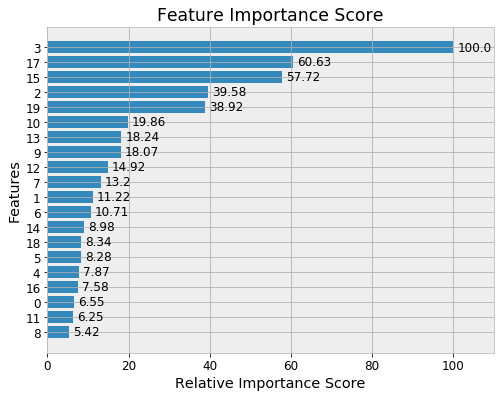

In [10]:
# we don't actually have the feature's actual name as those
# were simply randomly generated numbers, thus we simply supply
# a number ranging from 0 ~ the number of features
feature_names = np.arange(X_train.shape[1])
plot_xgboost_importance(xgboost_model = model_xgb, feature_names = feature_names)

Side note: Apart from using the built-in evaluation metric, we can also define one ourselves. The evaluation metric should be a function that takes two argument y_pred, y_true (it doesn't have to named like this). It is assumed that y_true will be a DMatrix object so that we can call the `get_label` method to access the true labels. As for the return value, the function ust return a str, value pair where the str is a name for the evaluation metric and value is the value of the evaluation. This objective is always minimized.

In [11]:
def misclassified(y_pred, y_true):
    """
    custom evaluation metric for xgboost, the metric
    counts the number of misclassified examples assuming 
    that classes with p>0.5 are positive
    """
    labels = y_true.get_label() # obtain true labels
    preds = y_pred > 0.5 # obtain predicted values
    return 'misclassified', np.sum(labels != preds)


model_xgb.fit(X_train, y_train, 
              eval_metric = misclassified, eval_set = eval_set,
              early_stopping_rounds = 5, verbose = 10)

ntree_limit = model_xgb.best_ntree_limit
y_pred_prob = model_xgb.predict_proba(X_test, ntree_limit = ntree_limit)[:, 1]
print('auc:', roc_auc_score(y_test, y_pred_prob))

[0]	validation_0-error:0.08625	validation_1-error:0.155	validation_0-misclassified:69	validation_1-misclassified:31
Multiple eval metrics have been passed: 'validation_1-misclassified' will be used for early stopping.

Will train until validation_1-misclassified hasn't improved in 5 rounds.
[10]	validation_0-error:0.045	validation_1-error:0.12	validation_0-misclassified:36	validation_1-misclassified:24
Stopping. Best iteration:
[5]	validation_0-error:0.0575	validation_1-error:0.12	validation_0-misclassified:46	validation_1-misclassified:24

auc: 0.935467683661


Another example of writing the customized rsquared evaluation metric.

```python
def rsquared(y_pred, y_true):
    """rsquared evaluation metric for xgboost's regression"""
    labels = y_true.get_label()
    sse = np.sum((labels - y_pred) ** 2)
    sst = np.sum((labels - np.mean(labels)) ** 2)
    rsquared = 1 - sse / sst
    
    # note that the documentation says the 
    # objective function is minimized, thus
    # we take the negative sign of rsquared
    return 'r2', -rsquared
```


## Hyperparamter Tuning (Random Search)

Next, since overfitting is a common problem with sophisticated algorithms like gradient boosting, we'll introduce ways to tune the model's hyperparameter and deal with them. If a xgboost model is too complex we can try:

- Reduce `max_depth`, the depth of each tree.
- Increase `min_child_weight`, minimum sum of obervation's weight needed in a child (think of it as the number of observation's needed in a tree's node).
- Increase `gamma`, the minimum loss reduction required to make a further partition.
- Increase regularization parameters, `reg_lambda` (l2 regularization) and `reg_alpha` (l1 regularization).
- Add more randomness by using `subsample` (the fraction of observations to be randomly samples for fitting each tree), `colsample_bytree` (the fraction of columns to be randomly samples for fitting each tree) parameters.

We'll use a [`Random Search`](http://scikit-learn.org/stable/modules/grid_search.html#randomized-parameter-optimization) to tune the model's hyperparameter.

In [12]:
def build_xgboost(X_train, y_train, X_test, y_test, n_iter):
    """
    random search hyperparameter tuning for xgboost
    classification task, n_iter controls the number
    of hyperparameter combinations that it will search for
    """
    # xgboost base parameter:
    xgb_param_fixed = {        
        # setting it to a positive value 
        # might help when class is extremely imbalanced
        # as it makes the update more conservative
        'max_delta_step': 1,
            
        # use all possible cores for training
        'n_jobs': -1,
        
        # set number of estimator to a large number
        # and the learning rate to be a small number,
        # we'll let early stopping decide when to stop
        'n_estimators': 300,
        'learning_rate': 0.1,
    }
    xgb_base = XGBClassifier(**xgb_param_fixed)

    # random search's parameter:
    # scikit-learn's random search works with distributions; 
    # but it must provide a rvs method for sampling values from it,
    # such as those from scipy.stats.distributions
    # randint: discrete random variables ranging from low to high
    # uniform: uniform continuous random variable between loc and loc + scale
    xgb_param_options = {
        'max_depth': randint(low = 3, high = 15),
        'colsample_bytree': uniform(loc = 0.7, scale = 0.3),
        'subsample': uniform(loc = 0.7, scale = 0.3)
    }
    
    eval_set = [(X_train, y_train), (X_test, y_test)]
    xgb_fit_params = {   
        'eval_metric': 'auc', 
        'eval_set': eval_set,
        'early_stopping_rounds': 5,
        'verbose': False
    }

    model_xgb = RandomizedSearchCV(
        estimator = xgb_base,
        param_distributions = xgb_param_options,
        fit_params = xgb_fit_params,
        cv = 10,   
        
        # number of parameter settings that are sampled
        n_iter = n_iter,
        
        # n_jobs can be a parameter (since it's a fast task
        # for this toy dataset, we'll simply we using 1 jobs)
        n_jobs = 1,
        verbose = 1
    ).fit(X_train, y_train)
    
    print('Best score obtained: {0}'.format(model_xgb.best_score_))
    print('Best Parameters:')
    for param, value in model_xgb.best_params_.items():
        print('\t{}: {}'.format(param, value))
    
    return model_xgb.best_estimator_

In [13]:
xgb_model = build_xgboost(X_train, y_train, X_test, y_test, n_iter = 15)
ntree_limit = xgb_model.best_ntree_limit
y_pred_prob = xgb_model.predict_proba(X_test, ntree_limit = ntree_limit)[:, 1]
print('auc:', roc_auc_score(y_test, y_pred_prob))

Fitting 10 folds for each of 15 candidates, totalling 150 fits
Best score obtained: 0.8975
Best Parameters:
	max_depth: 9
	colsample_bytree: 0.8884167609167009
	subsample: 0.7397495923292399
auc: 0.947310317142


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   10.1s finished


# Reference

- [Online Course: practical xgboost in python](http://education.parrotprediction.teachable.com/courses/practical-xgboost-in-python)
- [XGBoost Documentation: Installing Guide](https://github.com/dmlc/xgboost/blob/master/doc/build.md)
- [XGBoost Documentation: Python API documentation](http://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn)
- [XGBoost Documentation: Learning Task Parameters](http://xgboost.readthedocs.io/en/latest//parameter.html#learning-task-parameters)
- [Blog: Installing XGBoost on Mac OSX](https://www.ibm.com/developerworks/community/blogs/jfp/entry/Installing_XGBoost_on_Mac_OSX?lang=en)
- [Blog: Complete Guide to Parameter Tuning in XGBoost](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/)
- [Blog: Avoid Overfitting By Early Stopping With XGBoost In Python](http://machinelearningmastery.com/avoid-overfitting-by-early-stopping-with-xgboost-in-python/)